In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

In [8]:
# Ignore any warning
import warnings
warnings.filterwarnings('ignore')

In [9]:
factors = pd.read_csv('./datasets/covid-state-data-agg/COVID19_state.csv')
covid_cases = pd.read_csv('./datasets/covid-cases-data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
red_blue = pd.read_csv('./BlueRedStates.csv')
trips = pd.read_csv('./datasets/bts-travel-data/State_trips.csv')

In [10]:
factors.head()

,State,Tested,Infected,Deaths,Population,Pop Density,Gini,ICU Beds,Income,GDP,...,Hospitals,Health Spending,Pollution,Med-Large Airports,Temperature,Urban,Age 0-25,Age 26-54,Age 55+,School Closure Date
0,Alaska,620170,17057,84,734002,1.2863,0.4081,119,59687,73205,...,21,11064,6.4,1.0,26.6,66.0,0.36,0.39,0.25,03/19/20
1,Alabama,1356420,194892,2973,4908621,96.9221,0.4847,1533,42334,45219,...,101,7281,8.1,1.0,62.8,59.0,0.33,0.37,0.31,03/16/20
2,Arkansas,1363429,113641,1985,3038999,58.4030,0.4719,732,42566,42454,...,88,7408,7.1,0.0,60.4,56.2,0.34,0.37,0.30,03/17/20
3,Arizona,1792602,248139,5982,7378494,64.9550,0.4713,1559,43650,48055,...,83,6452,9.7,1.0,60.3,89.8,0.33,0.36,0.30,03/16/20
4,California,18912501,930628,17672,39937489,256.3727,0.4899,7338,62586,74205,...,359,7549,12.8,9.0,59.4,95.0,0.33,0.40,0.26,03/19/20


In [11]:
covid_cases.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,02/12/2021,UT,359641,359641.0,0.0,1060.0,0.0,1785,1729.0,56.0,11.0,2.0,02/13/2021 02:50:08 PM,Agree,Agree
1,03/01/2021,CO,438745,411869.0,26876.0,677.0,60.0,5952,5218.0,734.0,1.0,0.0,03/01/2021 12:00:00 AM,Agree,Agree
2,08/22/2020,AR,56199,NaN,NaN,547.0,0.0,674,NaN,NaN,11.0,0.0,08/23/2020 02:15:28 PM,Not agree,Not agree
3,07/17/2020,MP,37,37.0,0.0,1.0,0.0,2,2.0,0.0,0.0,0.0,07/19/2020 12:00:00 AM,Agree,Agree
4,08/12/2020,AS,0,NaN,NaN,0.0,0.0,0,NaN,NaN,0.0,0.0,08/13/2020 02:12:28 PM,NaN,NaN


In [12]:
covid_cases['submission_date'] = pd.to_datetime(covid_cases['submission_date'])

In [13]:
covid_cases = covid_cases.sort_values(by='submission_date', ascending = True)

In [14]:
covid_cases.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
34662,2020-01-22,OK,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,Not agree,Agree
37346,2020-01-22,AK,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,NaN,NaN
14129,2020-01-22,GU,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,Not agree,Not agree
23524,2020-01-22,VT,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,Not agree,Not agree
29492,2020-01-22,VA,0,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,03/26/2020 04:22:39 PM,Agree,Agree


In [15]:
covid_cases2 = covid_cases.loc[(covid_cases['submission_date'] < '2021-01-01')]

In [16]:
tot_cases = covid_cases2.groupby('state').sum()[['new_case']]
tot_cases['new_case']['NY'] = sum(tot_cases.loc['NYC'], tot_cases.loc['NY'])

In [17]:
red_blue.head()

,stateName,stateCode,BlueRed
0,Arizona,AZ,B
1,California,CA,B
2,Colorado,CO,B
3,Connecticut,CT,B
4,Delaware,DE,B


In [18]:
BR_totcases = tot_cases.merge(red_blue, left_on='state', right_on='stateCode')

In [19]:
factors_BR_totcases = BR_totcases.merge(factors, left_on='stateName', right_on='State')

In [20]:
factors_BR_totcases['Case Rates'] = factors_BR_totcases['new_case']/factors_BR_totcases['Population']

In [21]:
trips['Date'] = pd.to_datetime(trips['Date'])
trips2 = trips.loc[((trips['Date'] < '2021-01-01') & (trips['Date'] > '2019-12-31'))]

In [22]:
#trips2['Number of Trips'] = trips2['Number of Trips'].astype('str')
#trips2['Number of Trips'] = trips2['Number of Trips'].replace(',', '')
trips2['Number of Trips'].replace(',','', regex=True, inplace=True)
trips2['Number of Trips'] = trips2['Number of Trips'].apply(pd.to_numeric,errors='coerce')
trips3 = trips2.groupby('State Postal Code').sum()[['Number of Trips']]

In [23]:
#merging trip aggregate data with other data into final data table
final_data = factors_BR_totcases.merge(trips3, left_on='stateCode', right_on='State Postal Code')
final_data['Travel Rates'] = final_data['Number of Trips']/final_data['Population']

In [24]:
final_data.set_index('stateCode',inplace=True)

In [25]:
clean_data = final_data.drop(columns = ['new_case','stateName','State','Tested','Infected','Deaths','Pop Density',
                                        'Flu Deaths','Respiratory Deaths','School Closure Date', 'Number of Trips'])

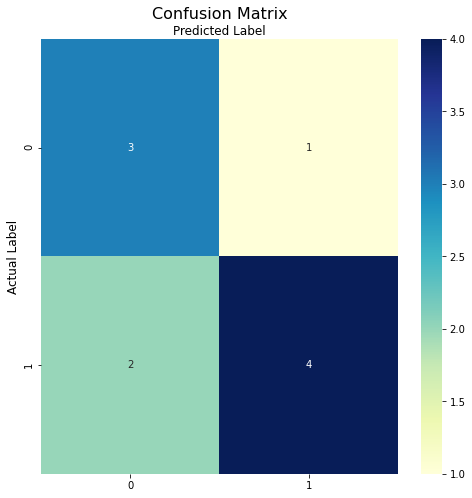

In [26]:
X = clean_data.copy().drop(columns = 'BlueRed')
Y = clean_data['BlueRed']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,
                                                   shuffle = False)

selector = SelectFromModel(estimator=LogisticRegression()).fit(X_train, 
                                                               Y_train)
coefs = selector.estimator_.coef_
thresh = selector.threshold_
support = selector.get_support()
X_selected = selector.transform(X_train)
X_test = selector.transform(X_test)
logistic = LogisticRegression(penalty='l1',solver='liblinear',
                               random_state=7).fit(X_selected, Y_train)
Y_pred = logistic.predict(X_test)

confusion = metrics.confusion_matrix(Y_test, Y_pred)
fig, ax = plt.subplots(figsize = [8,8])
sns.heatmap(confusion, annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion Matrix', size = 16)
plt.xlabel('Predicted Label', size = 12)
plt.ylabel('Actual Label', size = 12)
ax.xaxis.set_label_position("top")
plt.show()

# Y_true = []
# for idx in range(0,Y_pred.size):
#     if Y_pred[idx] == Y_test[idx]:
#         Y_true.append(1)
#     else:
#         Y_true.append(0)

Y_test_num = []
for idx in range(0, Y_test.size):
    if Y_test[idx] == 'B':
        Y_test_num.append(1)
    else:
        Y_test_num.append(0)

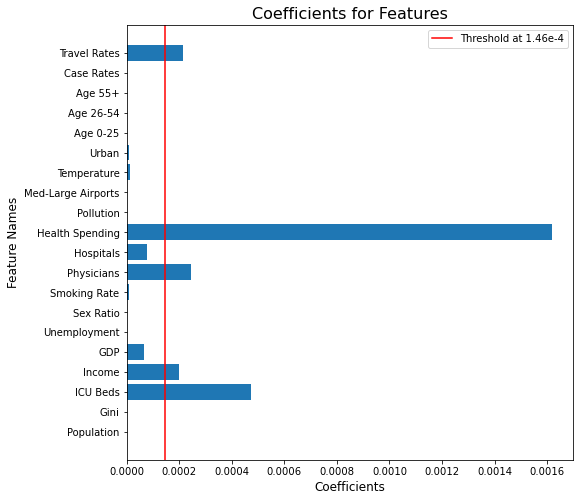

In [27]:
feature_names = X.columns
importance = abs(coefs.T[:,0])
plt.figure(figsize = (8,8))
plt.barh(np.linspace(1,len(importance),len(importance)),importance,
         tick_label=feature_names) 
plt.axvline(x=thresh, color = 'r', label = 'Threshold at 1.46e-4')
plt.title('Coefficients for Features', size = 16)
plt.xlabel('Coefficients', size = 12)
plt.ylabel('Feature Names', size = 12)
plt.legend()
plt.show()

In [28]:
selected_features = []
for idx in range(0, len(X.columns)):
    if support[idx]:
        selected_features.append(X.columns[idx])
print('Selected Features:', selected_features)

Selected Features: ['ICU Beds', 'Income', 'Physicians', 'Health Spending', 'Travel Rates']


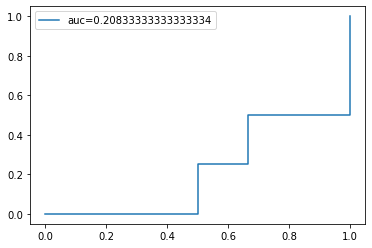

In [29]:
Y_pred_proba = logistic.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test_num,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test_num, Y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend()
plt.show()